<a href="https://colab.research.google.com/github/ernanhughes/boosting-examples/blob/main/Gradient-Boost-Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boost Regression

In this notebook, I will work through the implementation of a Gradient Boost Tree Regressor. Specifically, the algorithm implemented will be **Algorithm 3: LAD_TreeBoost** (see Friedman 2001). I will use the diabetes dataset, available on scikit-learn, to test this code.

In [1]:
## imports ##
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

Let's now create a class that will encapsulate the Gradient Boost Tree Regression algorithm:

In [2]:
## gradient boost tree regressor ##
class GradientBoostTreeRegressor(object):
    #initialiser
    def __init__(self, n_elements : int = 100, max_depth : int = 1) -> None:
        self.max_depth     = max_depth
        self.n_elements    = n_elements
        self.f             = []
        self.regions       = []
        self.gammas        = []
        self.mean_loss     = []
        self.e0            = 0

    #destructor
    def __del__(self) -> None:
        del self.max_depth
        del self.n_elements
        del self.f
        del self.regions
        del self.gammas
        del self.mean_loss
        del self.e0

    #private function to group data points & compute gamma parameters
    def __compute_gammas(self, yp : np.array, y_train : np.array, e : np.array) -> Tuple[np.array,Dict]:
        #initialise global gamma array
        gamma_jm = np.zeros((y_train.shape[0]))
        #iterate through each unique predicted value/region
        regions = np.unique(yp)
        gamma   = {}
        for r in regions:
            #compute index for r
            idx = yp == r
            #isolate relevant data points
            e_r = e[idx]
            y_r = y_train[idx]
            #compute the optimal gamma parameters for region r
            gamma_r = np.median(y_r - e_r)
            #populate the global gamma array
            gamma_jm[idx] = gamma_r
            #set the unique region <-> gamma pairs
            gamma[r] = gamma_r
        #append the regions to internal storage
        self.regions.append(regions)
        #return
        return((gamma_jm,gamma))

    #public function to train the ensemble
    def fit(self, X_train : np.array, y_train : np.array) -> None:
        #reset the internal class members
        self.f             = []
        self.regions       = []
        self.model_weights = []
        self.mean_loss     = []
        #initialise the ensemble & store initialisation
        e0      = np.median(y_train)
        self.e0 = np.copy(e0)
        e       = np.ones(y_train.shape[0]) * e0
        #loop through the specified number of iterations in the ensemble
        for _ in range(self.n_elements):
            #store mae loss
            self.mean_loss.append(np.mean(np.abs(y_train - e)))
            #compute the gradients of our loss function
            g = np.sign(y_train - e)
            #initialise a weak learner & train
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X_train,g)
            #compute optimal gamma coefficients
            yp             = model.predict(X_train)
            gamma_jm,gamma = self.__compute_gammas(yp,y_train,e)
            #update the ensemble
            e += gamma_jm
            #store trained ensemble elements
            self.f.append(model)
            self.gammas.append(gamma)

    #public function to generate predictions
    def predict(self, X_test : np.array) -> np.array:
        #initialise predictions
        y_pred = np.ones(X_test.shape[0]) * np.copy(self.e0)
        #cycle through each element in the ensemble
        for model,gamma,regions in zip(self.f,self.gammas,self.regions):
            #produce predictions using model
            y = model.predict(X_test)
            #cycle through each unique leaf node for model m
            for r in regions:
                #updates for region r
                idx = y == r
                y_pred[idx] += gamma[r]
        #return predictions
        return(y_pred)

    #public function to return mean training loss
    def get_loss(self) -> List:
        return(self.mean_loss)

    #public function to return model parameters
    def get_params(self, deep : bool = False) -> Dict:
        return {'n_elements':self.n_elements,
                'max_depth':self.max_depth}

## Gradient Boost Regression

### Load Regression Dataset

Here I'll load the diabetes dataset, available from scikit-learn. As I have already explored these data in the article on Adaboost Regression, I won't repeat it here.

A full description of this dataset is available here: https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset. The features in the predictor dataframe are as follows:

* **age** age in years
* **sex**
* **bmi** body mass index
* **bp** average blood pressure
* **s1** tc, total serum cholesterol
* **s2** ldl, low-density lipoproteins
* **s3** hdl, high-density lipoproteins
* **s4** tch, total cholesterol / HDL
* **s5** ltg, possibly log of serum triglycerides level
* **s6** glu, blood sugar level

The target is a quantitative measure of disease progression one year after baseline.

Let's begin by loading in these data:

In [3]:
## load regression dataset ##
dfX,sy = load_diabetes(return_X_y=True,as_frame=True)

### Investigate Training Loss

Here I want to look at how the training loss evolves as decision trees are added to the ensemble. In addition, I want to see what affect increasing the maximum depth, of the aforementioned decision trees, will have.  The loss function displayed is the *mean absolute error*  $\sum_i^N abs(y^{pred}_i - y^{true}_i)$, at each iteration during training.

Now I will declare an instance of our custom gradient boost tree regressor for a series of *max_depth* values. Following each declaration, I will train the model on the raw data features, since decision trees typically require little in the way of preparatory feature engineering:

In [4]:
## train the gradient boost regressor with default max_depth ##
rgr = GradientBoostTreeRegressor(n_elements=100)
rgr.fit(dfX.values,sy.values)

In [5]:
## collect loss ##
loss1 = rgr.get_loss()

In [6]:
## train the gradient boost regressor with max_depth = 2 ##
rgr = GradientBoostTreeRegressor(n_elements=100, max_depth=2)
rgr.fit(dfX.values,sy.values)

In [7]:
## collect loss ##
loss2 = rgr.get_loss()

In [8]:
## train the gradient boost regressor with max_depth = 3 ##
rgr = GradientBoostTreeRegressor(n_elements=100, max_depth=3)
rgr.fit(dfX.values,sy.values)

In [9]:
## collect loss ##
loss3 = rgr.get_loss()

In [10]:
## train the gradient boost regressor with max_depth = 4 ##
rgr = GradientBoostTreeRegressor(n_elements=100, max_depth=4)
rgr.fit(dfX.values,sy.values)

In [11]:
## collect loss ##
loss4 = rgr.get_loss()

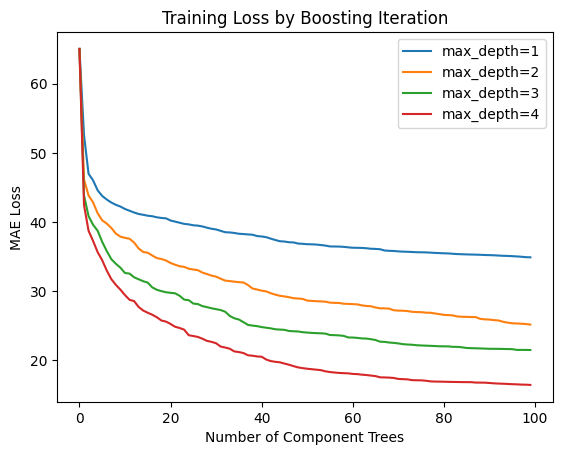

In [12]:
## plot different training losses ##
plt.plot(loss1,label='max_depth=1')
plt.plot(loss2,label='max_depth=2')
plt.plot(loss3,label='max_depth=3')
plt.plot(loss4,label='max_depth=4')
plt.title('Training Loss by Boosting Iteration')
plt.xlabel('Number of Component Trees')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

It is apparent that each model starts with a large loss value, which then declines rapidly before flattening out. It isn't too surprising to see that ensembles with deeper trees achieve lower training losses. These models are expressive enough such that the data can be more accurately modelled earlier in the boosting sequence, while the boosting procedure tackles any bias present.

### Investigate Performance

**Note**: rerunning these cells will show some fluctuation in the results

Here I will use 10-fold cross-validation to measure the performance of the Gradient Boost regressor. I will set the maximum number of elements to 20, and use a maximum depth of 1:

In [13]:
## define the scoring metrics ##
scoring_metrics = {'mse' : make_scorer(mean_squared_error),
                   'mae': make_scorer(mean_absolute_error)}

In [14]:
## perform cross-validation for n_elements = 20 & max_depth=1 ##
#define the model
rgr = GradientBoostTreeRegressor(n_elements=20,max_depth=1)
#cross validate
dcScores = cross_validate(rgr,dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

Mean MSE: 3567.06
Mean MAE: 46.59


We can compare these results with the Gradient Boost regressor available from scikit-learn:

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
## perform cross-validation for n_estimators = 20 & max_depth=1 ##
#define the model
rgr = GradientBoostingRegressor(n_estimators=20,max_depth=1,loss='lad',learning_rate=1.0)
#cross validate
dcScores = cross_validate(rgr,dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "d:\projects\boosting\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\projects\boosting\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\projects\boosting\.venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\projects\boosting\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of GradientBoostingRegressor must be a str among {'squared_error', 'quantile', 'huber', 'absolute_error'}. Got 'lad' instead.


We can see that both Gradient Boost implementations perform approximately equivalently. Small differences between the two sets of results should be expected, due to the stochastic nature of the analysis.

Now let's compare our results with a lone decision tree weak learner, a Random Forest Regressor with 20 constituent estimators, and an Adaboost Regressor also with 20 constituent estimators:

In [ ]:
#cross validation for lone decision tree regressor of depth 1
dcScores = cross_validate(DecisionTreeRegressor(max_depth=1),dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

Mean MSE: 4751.55
Mean MAE: 56.68


In [ ]:
## perform cross-validation for random forest regressor of n_estimators=20 and max_depth=1 ##
#define the model
rgr = RandomForestRegressor(n_estimators=20,max_depth=1)
#cross validate
dcScores = cross_validate(rgr,dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

Mean MSE: 3839.32
Mean MAE: 51.68


In [ ]:
## perform cross-validation for linear loss & n_estimators=20 ##
#define the model
rgr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), loss='linear', n_estimators=20)
#cross validate
dcScores = cross_validate(rgr,dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

Mean MSE: 3758.68
Mean MAE: 51.71


Model | Number of Elements | MSE | MAE
--- | --- | --- | ---
Custom Gradient Boost | 20 | 3548.21 | 46.56
Scikit-learn Gradient Boost | 20 | 3549.82 | 46.65
Decision Stump | NA | 4751.55 | 56.68
Scikit-Learn Random Forest | 20 | 3839.32 | 51.68
Scikit-Learn Adaboost | 20 | 3758.68 | 51.71

It is clear that the Gradient Boost Ensembles are the best performing models in this comparison. Adaboost takes second place, followed closely by the Random Forest. Unsurprisingly, the lone Decision Stump is the worst performing model attempted.

This small analysis demonstrates the predictive potential of Gradient Boosters. It is easy to understand why they have become popular for many applications and online competitions.